## Introduction

In this notebook, we'll show how to serialize the three separate components of Stable Diffusion as SavedModels:

* Text encoder
* Diffusion model
* Decoder

The SavedModels are needed to be able to deploy using TensorFlow Serving and the TF deployment ecosystem in general.

For each of the above components, we'll first serialize them as a SavedModel resource. We'll then show how to load the SavedModels individually and run inference with them.

We'll conclude by collating all the SavedModels together and invoking them in succession so that users can provide text prompts as inputs and get generated images as outputs. 

## Installation

In [ ]:
!pip install tensorflow==2.11 -q
!pip install tensorflow_datasets -q
!pip install keras_cv==0.4.0 -q

## Imports

In [2]:
import time
import base64
import keras_cv
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

2023-01-02 04:41:27.575571: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-02 04:41:28.331153: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/compat/lib.real:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-01-02 04:41:28.331281: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBR

You do not have pycocotools installed, so KerasCV pycoco metrics are not available. Please run `pip install pycocotools`.


In [3]:
keras_cv.__version__

'0.4.0'

In [4]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-01-02 04:41:30.613001: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-02 04:41:31.022438: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /device:GPU:0 with 38433 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:a1:00.0, compute capability: 8.0


True

In [5]:
from keras_cv.models.stable_diffusion.text_encoder import TextEncoder
from keras_cv.models.stable_diffusion.diffusion_model import DiffusionModel
from keras_cv.models.stable_diffusion.decoder import Decoder

## Model instantiation

In [6]:
MAX_PROMPT_LENGTH = 77
IMG_HEIGHT = 512
IMG_WIDTH = 512

text_encoder = TextEncoder(MAX_PROMPT_LENGTH)
diffusion_model = DiffusionModel(IMG_HEIGHT, IMG_WIDTH, MAX_PROMPT_LENGTH)
decoder = Decoder(IMG_HEIGHT, IMG_WIDTH)

2023-01-02 04:41:49.978766: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38433 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:a1:00.0, compute capability: 8.0


492466864/492466864 [==============================] - 10s 0us/step
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
198180272/198180272 [==============================] - 4s 0us/step


## Diffusion model (that refines the latent)

The diffusion model takes several steps to refine the provided latent inputs. Say you have deployed the diffusion model as is as some endpoint. In its trivial form, you'd then have to call the deployed endpoint several times for the refinement step. The SavedModel serialized below wraps this entire logic so that you don't have to call the endpoint multiple times for refinement.

In [9]:
from keras_cv.models.stable_diffusion.constants import _ALPHAS_CUMPROD
import tensorflow as tf

signature_dict = {
  "context": tf.TensorSpec([None], tf.string, name="context"),
  "unconditional_context": tf.TensorSpec([None], tf.string, name="unconditional_context"),
  "num_steps": tf.TensorSpec(shape=[], dtype=tf.int32, name="num_steps"),
  "batch_size": tf.TensorSpec(shape=[], dtype=tf.int32, name="batch_size"),
}


def diffusion_model_exporter(model: tf.keras.Model):
  IMG_HEIGHT = 512
  IMG_WIDTH = 512
  MAX_PROMPT_LENGTH = 77
  _ALPHAS_CUMPROD_tf = tf.constant(_ALPHAS_CUMPROD)
  UNCONDITIONAL_GUIDANCE_SCALE = 7.5
  SEED = None

  @tf.function
  def get_timestep_embedding(timestep, batch_size, dim=320, max_period=10000):
    half = dim // 2
    log_max_preiod = tf.math.log(tf.cast(max_period, tf.float32))
    freqs = tf.math.exp(
        -log_max_preiod * tf.range(0, half, dtype=tf.float32) / half
    )
    args = tf.convert_to_tensor([timestep], dtype=tf.float32) * freqs
    embedding = tf.concat([tf.math.cos(args), tf.math.sin(args)], 0)
    embedding = tf.reshape(embedding, [1, -1])
    return tf.repeat(embedding, batch_size, axis=0)

  @tf.function(input_signature=[signature_dict])
  def serving_fn(inputs):
    img_height = tf.cast(tf.math.round(IMG_HEIGHT / 128) * 128, tf.int32)
    img_width = tf.cast(tf.math.round(IMG_WIDTH / 128) * 128, tf.int32)

    batch_size = inputs["batch_size"]
    num_steps = inputs["num_steps"]

    context = inputs["context"]
    context = tf.io.decode_base64(context)
    context = tf.strings.to_number(context)
    context = tf.reshape(context, (batch_size, 77, 768))

    unconditional_context = inputs["unconditional_context"]
    unconditional_context = tf.io.decode_base64(unconditional_context)
    unconditional_context = tf.strings.to_number(unconditional_context)
    unconditional_context = tf.reshape(unconditional_context, (batch_size, 77, 768))        

    latent = tf.random.normal((batch_size, img_height // 8, img_width // 8, 4))

    timesteps = tf.range(1, 1000, 1000 // num_steps)
    alphas = tf.map_fn(lambda t: _ALPHAS_CUMPROD_tf[t], timesteps, dtype=tf.float32)
    alphas_prev = tf.concat([[1.0], alphas[:-1]], 0)

    index = num_steps - 1
    latent_prev = None
    for timestep in timesteps[::-1]:
        latent_prev = latent
        t_emb = get_timestep_embedding(timestep, batch_size)
        unconditional_latent = model(
            [latent, t_emb, unconditional_context], training=False
        )
        latent = model([latent, t_emb, context], training=False)
        latent = unconditional_latent + UNCONDITIONAL_GUIDANCE_SCALE * (
            latent - unconditional_latent
        )
        a_t, a_prev = alphas[index], alphas_prev[index]
        pred_x0 = (latent_prev - tf.math.sqrt(1 - a_t) * latent) / tf.math.sqrt(a_t)
        latent = (
            latent * tf.math.sqrt(1.0 - a_prev) + tf.math.sqrt(a_prev) * pred_x0
        )
        index = index - 1

    latent = tf.reshape(latent, [batch_size*64*64*4])
    latent = tf.strings.as_string(latent)
    latent = tf.io.encode_base64(latent)

    return {"latent": latent}

  return serving_fn

In [10]:
tf.saved_model.save(
    diffusion_model,
    "./diffusion_model/1/",
    signatures={"serving_default": diffusion_model_exporter(diffusion_model)},
)

INFO:tensorflow:Assets written to: ./diffusion_model/1/assets


INFO:tensorflow:Assets written to: ./diffusion_model/1/assets


In [11]:
!saved_model_cli show --dir diffusion_model/1/ --tag_set serve --signature_def serving_default

2023-01-02 04:49:53.662201: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-02 04:49:54.413590: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/compat/lib.real:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-01-02 04:49:54.413666: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBR

In [12]:
from tensorflow.python.saved_model import tag_constants

saved_model_loaded = tf.saved_model.load(
    "./diffusion_model/1/", tags=[tag_constants.SERVING]
)
predict_fn = saved_model_loaded.signatures["serving_default"]

In [13]:
saved_model_loaded.signatures["serving_default"].structured_outputs

{'latent': TensorSpec(shape=(None,), dtype=tf.string, name='latent')}

In [14]:
batch_size = tf.constant(2)

context = tf.random.normal((batch_size, 77, 768))
context = tf.reshape(context, [batch_size*77*768])
context = tf.strings.as_string(context)
context = tf.io.encode_base64(context)

num_steps = tf.constant(10)

unconditional_context = tf.random.normal((batch_size, 77, 768))
unconditional_context = tf.reshape(unconditional_context, [batch_size*77*768])
unconditional_context = tf.strings.as_string(unconditional_context)
unconditional_context = tf.io.encode_base64(unconditional_context)

latent = tf.random.normal((batch_size, 64, 64, 4))

In [15]:
predict_fn(
    batch_size=batch_size,
    context=context,
    num_steps=num_steps,
    unconditional_context=unconditional_context,
)

2023-01-02 04:50:30.587410: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'StatefulPartitionedCall/while/next_iteration/_1475-0-0-TransposeNCHWToNHWC-LayoutOptimizer' -> 'StatefulPartitionedCall/while/merge/_1436'}.
2023-01-02 04:50:36.209317: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2023-01-02 04:50:36.302667: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


{'latent': <tf.Tensor: shape=(32768,), dtype=string, numpy=
 array([b'LTAuMDk1MjEw', b'LTAuNjg3NjI1', b'LTAuODgwNTAy', ...,
        b'LTAuMTg2Mjgy', b'MC4yNDQ2MDE', b'MC4yNjgyNTI'], dtype=object)>}

## Decoder (that generates images given the latents)

In [16]:
signature_dict = {
    "latent": tf.TensorSpec(shape=[None], dtype=tf.string, name="latent"),
    "batch_size": tf.TensorSpec(shape=[], dtype=tf.int32, name="batch_size"),
}

def decoder_exporter(model: tf.keras.Model):
  @tf.function(input_signature=[signature_dict])
  def serving_fn(inputs):
    batch_size = inputs["batch_size"]  

    latent = inputs["latent"]
    latent = tf.io.decode_base64(latent)
    latent = tf.strings.to_number(latent)
    latent = tf.reshape(latent, (batch_size, 64, 64, 4))    

    decoded = model(latent, training=False)
    decoded = ((decoded + 1) / 2) * 255

    images = tf.clip_by_value(decoded, 0, 255)
    images = tf.cast(images, tf.uint8)
    
    images = tf.reshape(images, [batch_size*512*512*3])
    images = tf.strings.as_string(images)
    images = tf.io.encode_base64(images)
    
    return {"generated_images": images}

  return serving_fn

In [17]:
tf.saved_model.save(
    decoder,
    "./decoder/1/",
    signatures={"serving_default": decoder_exporter(decoder)},
)

INFO:tensorflow:Assets written to: ./decoder/1/assets


INFO:tensorflow:Assets written to: ./decoder/1/assets


In [18]:
saved_model_loaded = tf.saved_model.load("./decoder/1/", tags=[tag_constants.SERVING])
decoder_predict_fn = saved_model_loaded.signatures["serving_default"]

In [19]:
batch_size = tf.constant(2)

latent = tf.random.normal((int(batch_size), 64, 64, 4))
latent = tf.reshape(latent, [batch_size*64*64*4])
latent = tf.strings.as_string(latent)
latent = tf.io.encode_base64(latent)

In [20]:
decoder_predict_fn(
    latent=latent,
    batch_size=batch_size
)

{'generated_images': <tf.Tensor: shape=(1572864,), dtype=string, numpy=
 array([b'MTE1', b'MTA5', b'OTQ', ..., b'ODk', b'NjQ', b'NTg'],
       dtype=object)>}

## Text encoder + tokenizer

The Tokenizer uses pure Python utilities and hence probably cannot be immediately serialized into a `tf.function`. The text encoder embeds the text prompt in the feature space. The text embeddings are a part of the inputs needed by the diffusion model.

In [21]:
from keras_cv.models.stable_diffusion.clip_tokenizer import SimpleTokenizer
from keras_cv.models.stable_diffusion.constants import _UNCONDITIONAL_TOKENS

In [22]:
signature_dict = {
    "tokens": tf.TensorSpec(shape=[None, 77], dtype=tf.int32, name="tokens"),
    "batch_size": tf.TensorSpec(shape=[], dtype=tf.int32, name="batch_size"),
}


def text_encoder_exporter(model: tf.keras.Model):
  MAX_PROMPT_LENGTH = 77
  POS_IDS = tf.convert_to_tensor([list(range(MAX_PROMPT_LENGTH))], dtype=tf.int32)
  UNCONDITIONAL_TOKENS = tf.convert_to_tensor([_UNCONDITIONAL_TOKENS], dtype=tf.int32)

  @tf.function(input_signature=[signature_dict])
  def serving_fn(inputs):
    batch_size = inputs["batch_size"]

    # context
    encoded_text = model([inputs["tokens"], POS_IDS], training=False)
    encoded_text = tf.squeeze(encoded_text)

    if tf.rank(encoded_text) == 2:
        encoded_text = tf.repeat(
            tf.expand_dims(encoded_text, axis=0), batch_size, axis=0
        )

    # unconditional context
    unconditional_context = model([UNCONDITIONAL_TOKENS, POS_IDS], training=False)
    unconditional_context = tf.repeat(unconditional_context, batch_size, axis=0)

    encoded_text = tf.reshape(encoded_text, [batch_size*77*768])
    encoded_text = tf.strings.as_string(encoded_text)
    encoded_text = tf.io.encode_base64(encoded_text)

    unconditional_context = tf.reshape(unconditional_context, [batch_size*77*768])
    unconditional_context = tf.strings.as_string(unconditional_context)
    unconditional_context = tf.io.encode_base64(unconditional_context)    

    return {"context": encoded_text, "unconditional_context": unconditional_context}

  return serving_fn

In [23]:
tf.saved_model.save(
    text_encoder,
    "./text_encoder/1/",
    signatures={"serving_default": text_encoder_exporter(text_encoder)},
)

INFO:tensorflow:Assets written to: ./text_encoder/1/assets


INFO:tensorflow:Assets written to: ./text_encoder/1/assets


In [24]:
saved_model_loaded = tf.saved_model.load(
    "./text_encoder/1/", tags=[tag_constants.SERVING]
)
text_encoder_predict_fn = saved_model_loaded.signatures["serving_default"]

In [25]:
text_encoder_predict_fn(
    tokens=tf.ones((int(batch_size), 77), tf.int32), batch_size=batch_size
)

{'context': <tf.Tensor: shape=(118272,), dtype=string, numpy=
 array([b'LTAuMzM0NjI3', b'MC4wMTAwOTQ', b'LTAuMDM5MDk4', ...,
        b'MC44MjA2ODI', b'LTAuNDcxNzEy', b'LTEuODQ4MDI0'], dtype=object)>,
 'unconditional_context': <tf.Tensor: shape=(118272,), dtype=string, numpy=
 array([b'LTAuMzg4Mzcz', b'MC4wMjI5Mzk', b'LTAuMDUyMTk2', ...,
        b'MS42MTA1NDE', b'LTEuMDE3MjI3', b'LTAuMjQ3ODA0'], dtype=object)>}

## An end-to-end example

In [26]:
tokenizer = SimpleTokenizer()
prompt = "photograph of an astronaut riding a horse in a green desert"
tokens = tokenizer.encode(prompt)

1356917/1356917 [==============================] - 0s 0us/step


### Tokenize

In [27]:
padding_token = 49407

tokens = tokens + [padding_token] * (MAX_PROMPT_LENGTH - len(tokens))
tokens = tf.convert_to_tensor([tokens], dtype=tf.int32)
tokens.shape

TensorShape([1, 77])

### Encode

In [28]:
batch_size = tf.constant(4)  # Denotes how many images to generate.

encoded_text = text_encoder_predict_fn(
    tokens=tokens,
    batch_size=batch_size,
)

### Generate the latents

In [30]:
num_steps = 25

latents = predict_fn(
    batch_size=batch_size,
    context=encoded_text["context"],
    num_steps=tf.convert_to_tensor(num_steps),
    unconditional_context=encoded_text["unconditional_context"],
)

### Decode the latents

In [31]:
latents.keys()

dict_keys(['latent'])

In [34]:
decoded_images = decoder_predict_fn(
    latent=latents["latent"],
    batch_size=batch_size
)

In [35]:
decoded_images = tf.io.decode_base64(decoded_images["generated_images"])
decoded_images = tf.strings.to_number(decoded_images, out_type=tf.dtypes.int32)
decoded_images = tf.reshape(decoded_images, (batch_size, 512, 512, 3))

In [36]:
decoded_images.shape

TensorShape([4, 512, 512, 3])

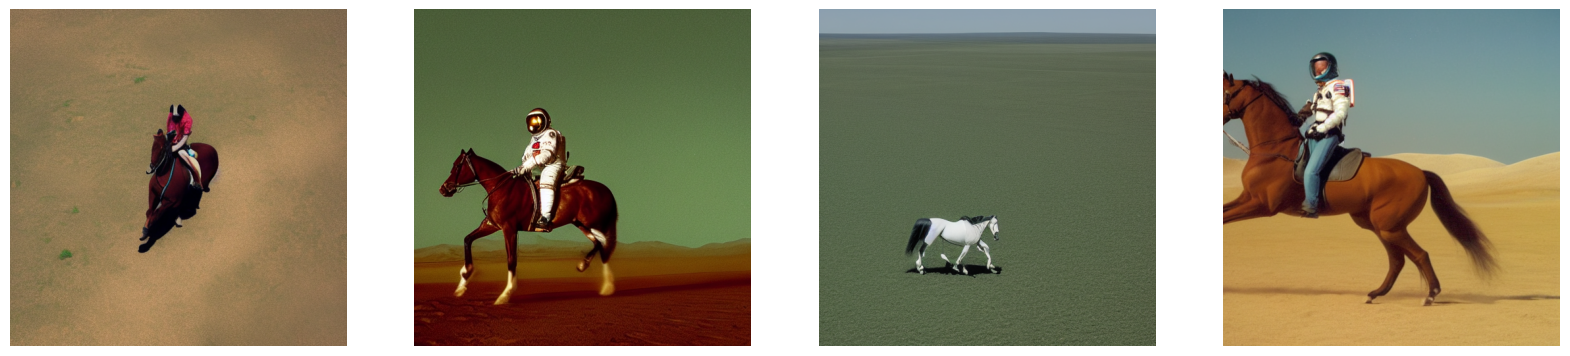

In [37]:
import matplotlib.pyplot as plt


def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")


plot_images(decoded_images.numpy())

### Putting things together in a function

In [38]:
import numpy as np

In [39]:
PADDING_TOKEN = 49407


def generate_images_from_text(
    text: str, batch_size: int = 4, num_steps: int = 25
) -> np.ndarray:
    batch_size = tf.constant(batch_size)
    num_steps = tf.constant(num_steps)

    tokens = tokenizer.encode(text)
    tokens = tokens + [PADDING_TOKEN] * (MAX_PROMPT_LENGTH - len(tokens))
    tokens = tf.convert_to_tensor([tokens], dtype=tf.int32)

    encoded_text = text_encoder_predict_fn(
        tokens=tokens,
        batch_size=batch_size,
    )

    latents = predict_fn(
        batch_size=batch_size,
        context=encoded_text["context"],
        num_steps=num_steps,
        unconditional_context=encoded_text["unconditional_context"],
    )

    decoded_images = decoder_predict_fn(
        latent=latents["latent"],
        batch_size=batch_size
    )
    decoded_images = tf.io.decode_base64(decoded_images["generated_images"])
    decoded_images = tf.strings.to_number(decoded_images, out_type=tf.dtypes.int32)
    decoded_images = tf.reshape(decoded_images, (batch_size, 512, 512, 3))    
    return decoded_images.numpy()

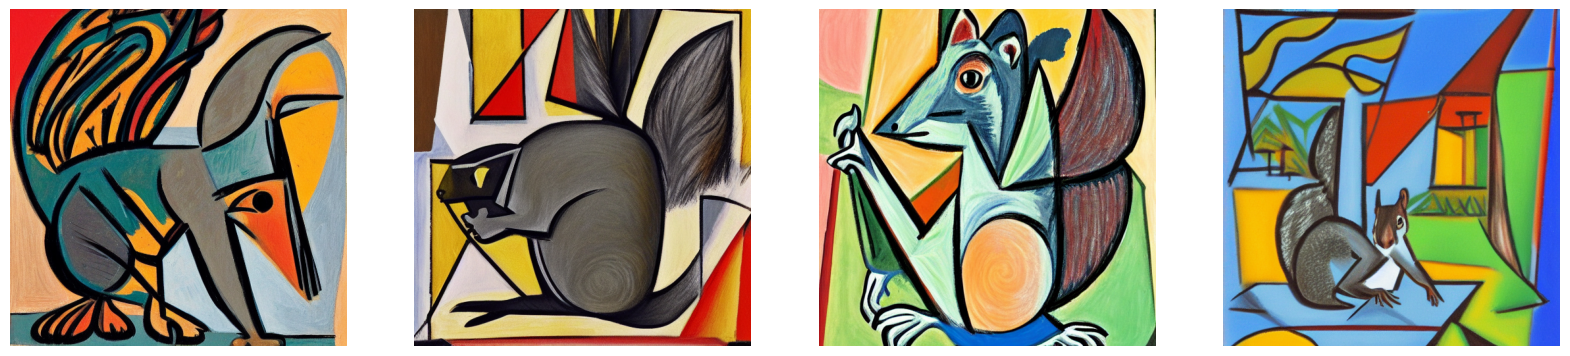

In [40]:
plot_images(generate_images_from_text("An image of a squirrel in Picasso style"))

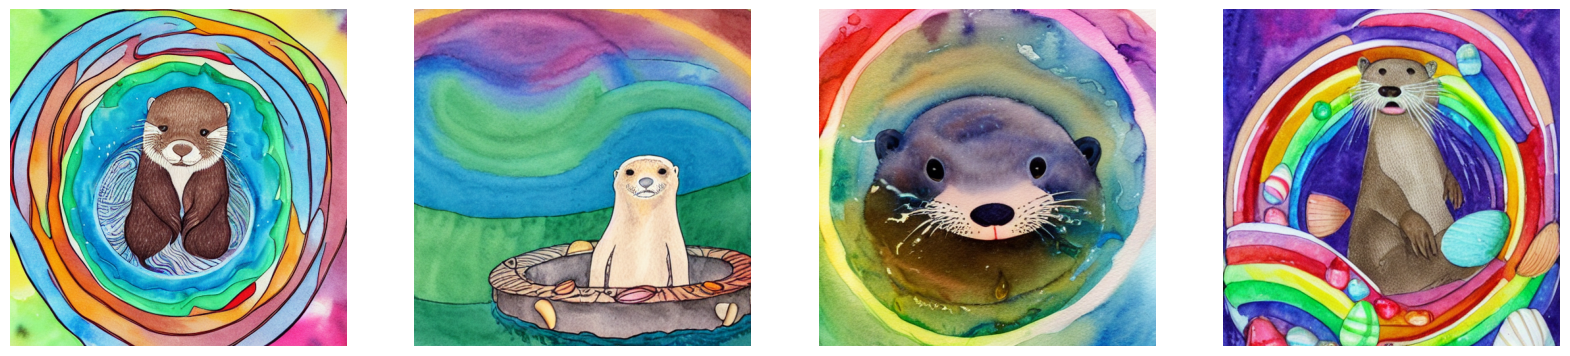

In [41]:
plot_images(
    generate_images_from_text(
        "A cute otter in a rainbow whirlpool holding shells, watercolor"
    )
)